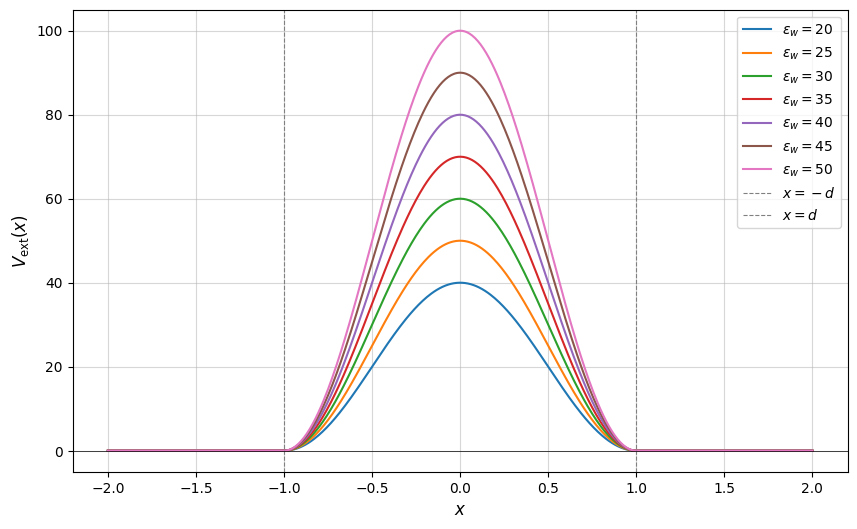

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 1.0  # Particle diameter
d = sigma    # Barrier width
ew_values = np.arange(20, 55, 5)  # Barrier strength values from 20 to 50 incrementing by 5

# Define the potential function
def V_ext(x, epsilon_w, d):
    H = lambda x: np.heaviside(x, 0.5)  # Heaviside step function
    return epsilon_w * (np.cos(np.pi * x / d) + 1) * H(d - x) * H(x + d)

# x range
x = np.linspace(-2 * d, 2 * d, 500)

# Plot
plt.figure(figsize=(10, 6))
for ew in ew_values:
    V = V_ext(x, ew, d)
    plt.plot(x, V, label=f"$\\epsilon_w = {ew}$")

plt.axvline(-d, color='gray', linestyle='--', label=r"$x = -d$", linewidth=0.8)
plt.axvline(d, color='gray', linestyle='--', label=r"$x = d$", linewidth=0.8)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$V_{\\text{ext}}(x)$", fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.5)
plt.show()

In [48]:
def inspect_file(filename):
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            print(f"Line {i + 1}: {line.strip()}")
            if i >= 10:  # Print only the first 10 lines
                break

inspect_file('dumps/wet.241206.0213.eps.20.ly.120.dump')

Line 1: # Chunk-averaged data for fix fprofile and group all
Line 2: # Timestep Number-of-chunks Total-count
Line 3: # Chunk Coord1 Ncount density/number
Line 4: 0 1920 14400
Line 5: 1 -119.938 10 0.666667
Line 6: 2 -119.812 9 0.6
Line 7: 3 -119.688 4 0.266667
Line 8: 4 -119.562 7 0.466667
Line 9: 5 -119.438 4 0.266667
Line 10: 6 -119.312 5 0.333333
Line 11: 7 -119.188 8 0.533333


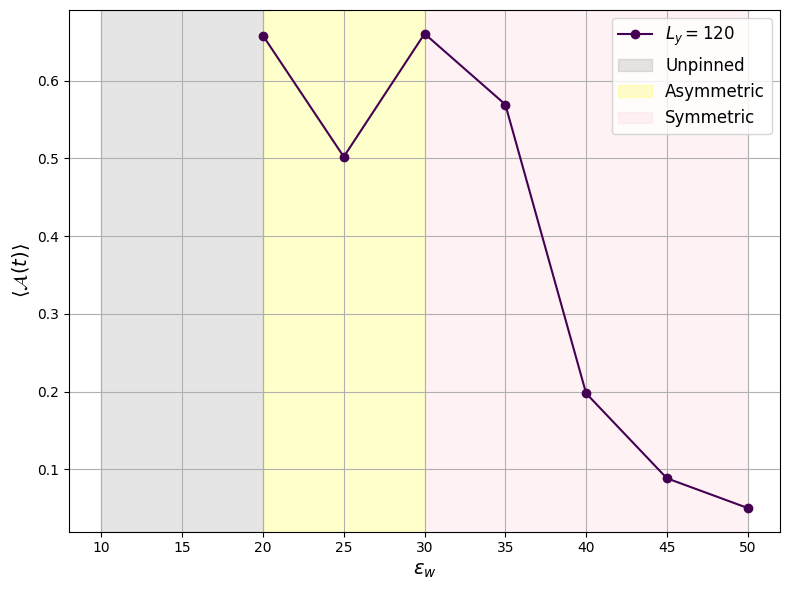

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

def load_profile(filename):
    """
    Load LAMMPS profile dump file into a pandas DataFrame.
    Reads multiple timesteps and returns a DataFrame containing data for all timesteps.
    """
    data = []
    with open(filename, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        # Skip comment lines and empty lines
        if line.startswith('#') or line == '':
            i += 1
            continue
        tokens = line.split()
        if len(tokens) == 3:
            # Try to parse the line as Timestep and Number-of-chunks
            try:
                timestep = int(tokens[0])
                chunk_count = int(tokens[1])
                # Total-count is ignored
            except ValueError:
                # If parsing fails, skip this line
                i += 1
                continue
            # Read the data for this timestep
            data_start = i + 1
            data_end = data_start + chunk_count
            for j in range(data_start, data_end):
                if j >= len(lines):
                    break  # Prevent index out of range
                dl = lines[j].strip()
                if dl == '':
                    continue
                dl_tokens = dl.split()
                if len(dl_tokens) != 4:
                    continue
                try:
                    chunk = int(dl_tokens[0])
                    coord1 = float(dl_tokens[1])
                    ncount = int(float(dl_tokens[2]))  # Convert to float first to handle possible decimals
                    density = float(dl_tokens[3])
                    data.append({
                        'Timestep': timestep,
                        'Chunk': chunk,
                        'Coord1': coord1,
                        'Ncount': ncount,
                        'density': density
                    })
                except ValueError:
                    continue  # Skip lines with invalid data
            i = data_end
        else:
            i += 1

    df = pd.DataFrame(data)
    return df  # Return the DataFrame with all timesteps

def calculate_asymmetry(data, lx, rho_ld, rho):
    """
    Compute the asymmetry order parameter A(t) with proper normalization.
    """
    x_bins = data['Coord1']  # Bin center positions along x-axis
    densities = data['density']  # Density per bin

    # Ensure that x_bins and densities are sorted according to x_bins
    sorted_indices = np.argsort(x_bins)
    x_bins = x_bins.iloc[sorted_indices].reset_index(drop=True)
    densities = densities.iloc[sorted_indices].reset_index(drop=True)

    bin_width = abs(x_bins.iloc[1] - x_bins.iloc[0])  # Calculate bin width

    # Split the bins into left and right of the barrier (x = 0)
    left_mask = x_bins < 0
    right_mask = x_bins > 0

    left_bins = densities[left_mask]
    right_bins = densities[right_mask]

    # Integrate density over the left and right regions
    left_integral = (left_bins * bin_width).sum()
    right_integral = (right_bins * bin_width).sum()

    # Numerator for A(t)
    numerator = abs(right_integral - left_integral)

    # Denominator normalisation
    denominator = (rho - rho_ld) * lx

    # Asymmetry order parameter
    asymmetry = numerator / denominator if denominator != 0 else 0

    return asymmetry

def process_dump_files(folder, lx, rho_ld, rho):
    """
    Process all dump files in the given folder to calculate asymmetry A(t).
    """
    results = {}

    # Regex to extract `ew` and `ly` from file names
    pattern = re.compile(r"wet\..*\.eps\.(\d+)\.ly\.(\d+)\.dump")

    for filename in os.listdir(folder):
        # Skip files that do not end with '.dump'
        if not filename.endswith(".dump"):
            continue

        match = pattern.match(filename)
        if match:
            ew = int(match.group(1))
            ly = int(match.group(2))

            # Ensure results dictionary is organized by `ly`
            if ly not in results:
                results[ly] = []

            filepath = os.path.join(folder, filename)
            try:
                data = load_profile(filepath)
                # Compute asymmetry at each timestep
                asymmetry_list = []
                grouped = data.groupby('Timestep')
                timesteps = list(grouped.groups.keys())

                # Exclude the first 2% of timesteps (empirical based on PotEng)
                start_index = int(len(timesteps) * 0.1) # 10%
                filtered_timesteps = timesteps[start_index:]

                # for timestep, df_timestep in grouped:
                for timestep in filtered_timesteps:
                    df_timestep = grouped.get_group(timestep)
                    asymmetry = calculate_asymmetry(df_timestep, lx=lx, rho_ld=rho_ld, rho=rho)
                    asymmetry_list.append(asymmetry)

                # Average asymmetry over time
                average_asymmetry = np.mean(asymmetry_list)
                results[ly].append((ew, average_asymmetry))
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
                continue

    # Sort results by `ew` for each `ly`
    for ly in results:
        results[ly].sort(key=lambda x: x[0])

    return results

def plot_asymmetry(results):
    """
    Plot asymmetry A(t) as a function of ew for different system sizes Ly.
    """
    plt.figure(figsize=(8, 6))

    # Assign colors and markers for each system size Ly
    num_ly = len(results)
    colors = plt.cm.viridis(np.linspace(0, 1, num_ly))
    markers = ['o', 's', 'D', '^', 'v', 'x', '*', '+', 'p', 'h']

    for i, (ly, data) in enumerate(sorted(results.items())):
        ew, asymmetry = zip(*data)
        plt.plot(ew, asymmetry, label=f"$L_y = {ly}$", color=colors[i % len(colors)], marker=markers[i % len(markers)])

    # Add shading to represent different regimes
    plt.axvspan(10, 20, color='black', alpha=0.1, label="Unpinned")
    plt.axvspan(20, 30, color='yellow', alpha=0.2, label="Asymmetric")
    plt.axvspan(30, 50, color='pink', alpha=0.2, label="Symmetric")

    plt.xlabel(r"$\epsilon_w$", fontsize=14)
    plt.ylabel(r"$\langle \mathcal{A}(t) \rangle$", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    folder = "dumps"  # Folder containing dump files
    lx = 240.0  # Total system size in x-direction
    rho_ld = 0.15  # Low-density MIPS value
    rho = 0.5  # Total system density

    # Process dump files and calculate asymmetry
    results = process_dump_files(folder, lx=lx, rho_ld=rho_ld, rho=rho)

    # Check if results are obtained
    if results:
        # Plot the asymmetry order parameter
        plot_asymmetry(results)
    else:
        print("No results to plot.")


Computed tau_r (persistence time): 104.16666666666667


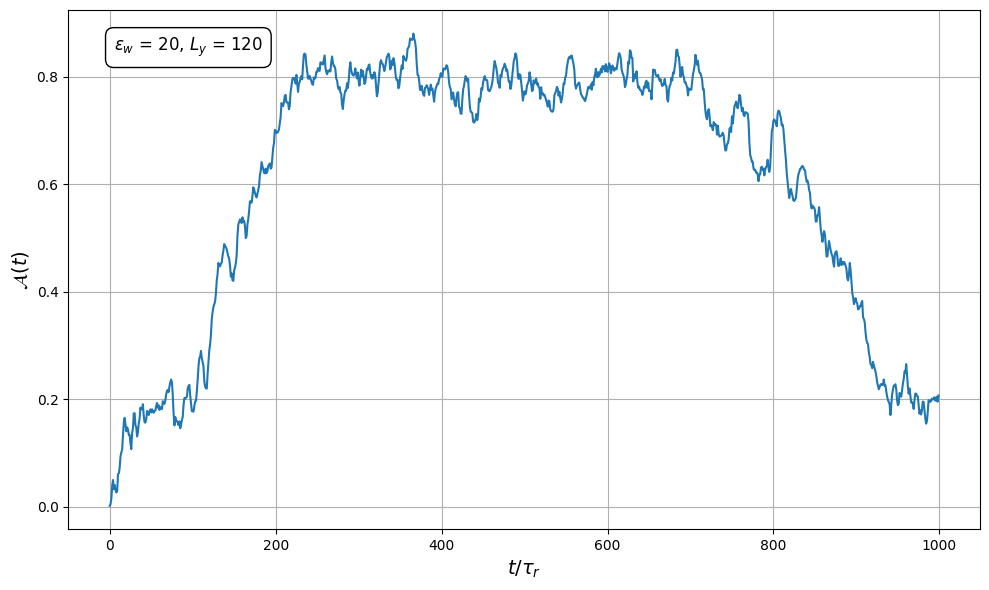

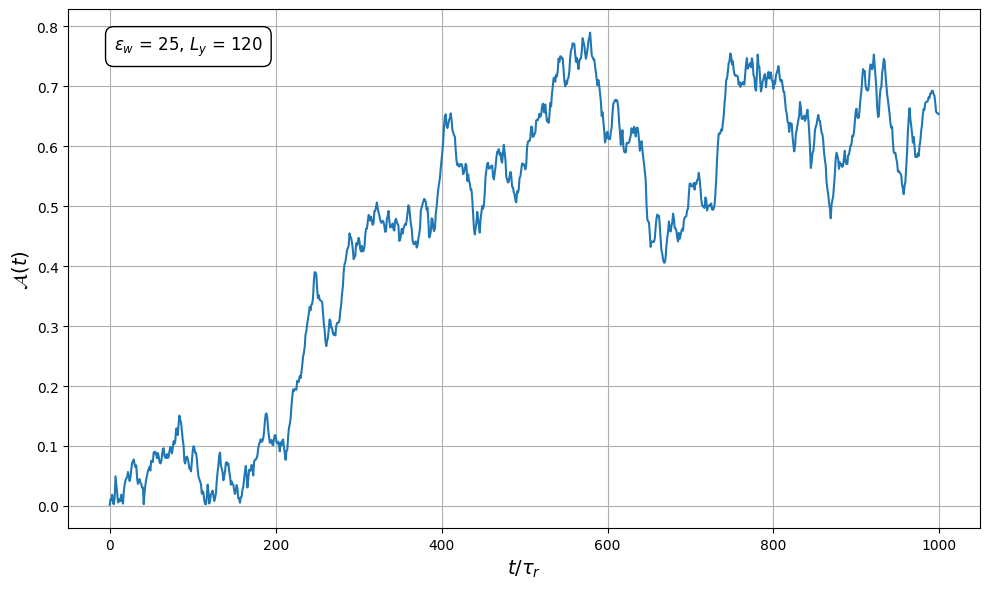

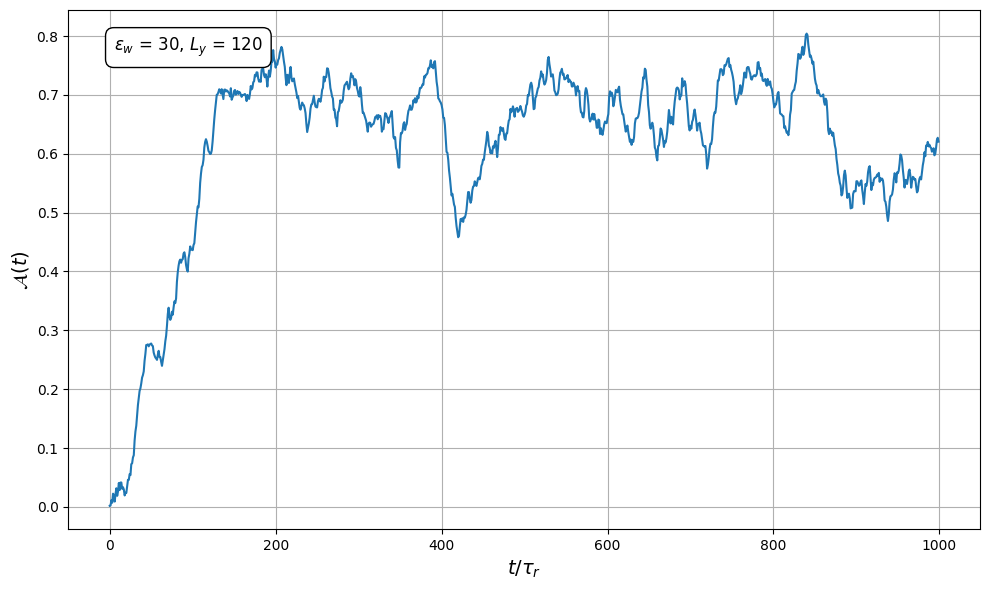

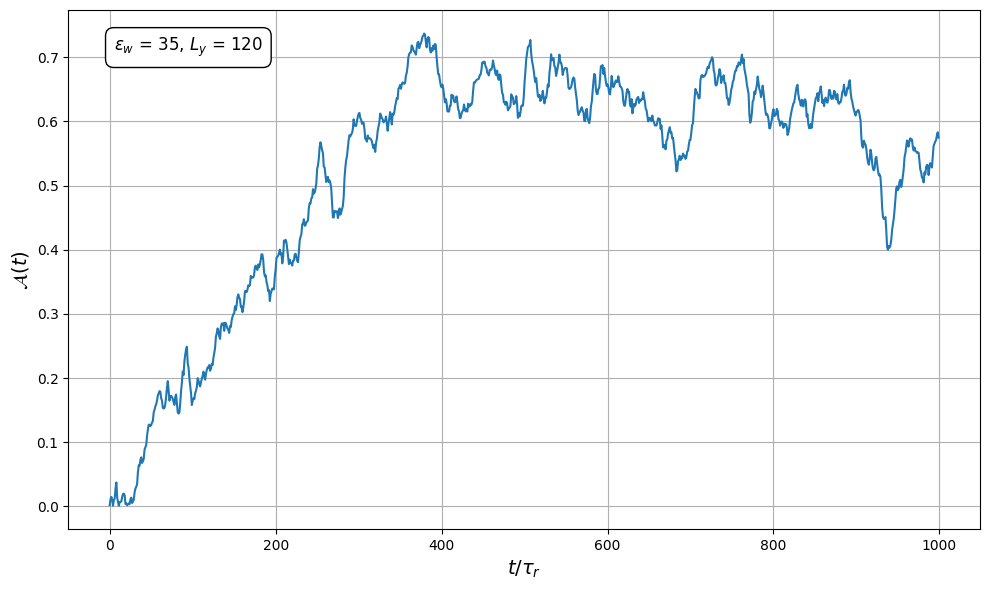

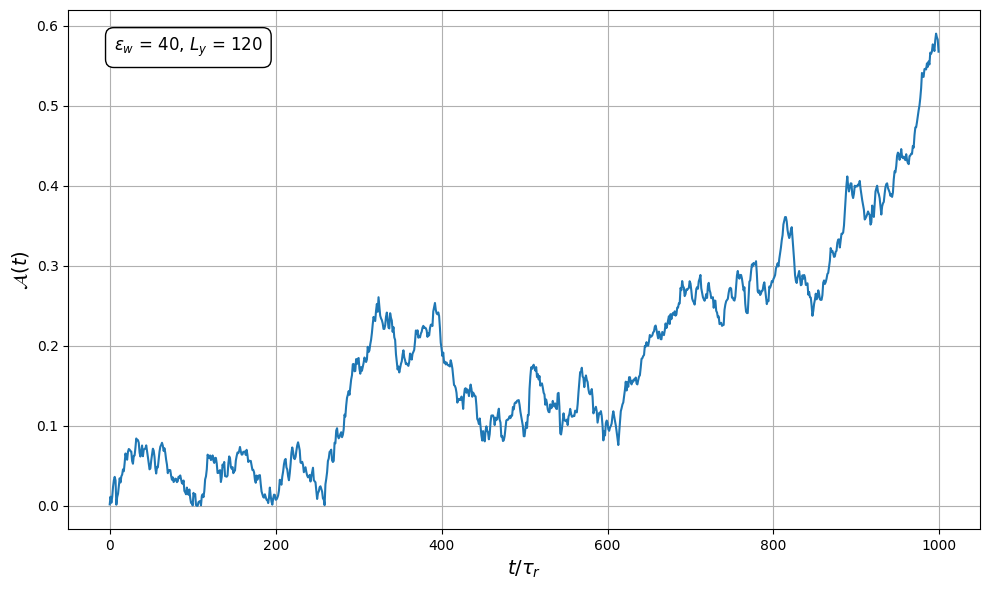

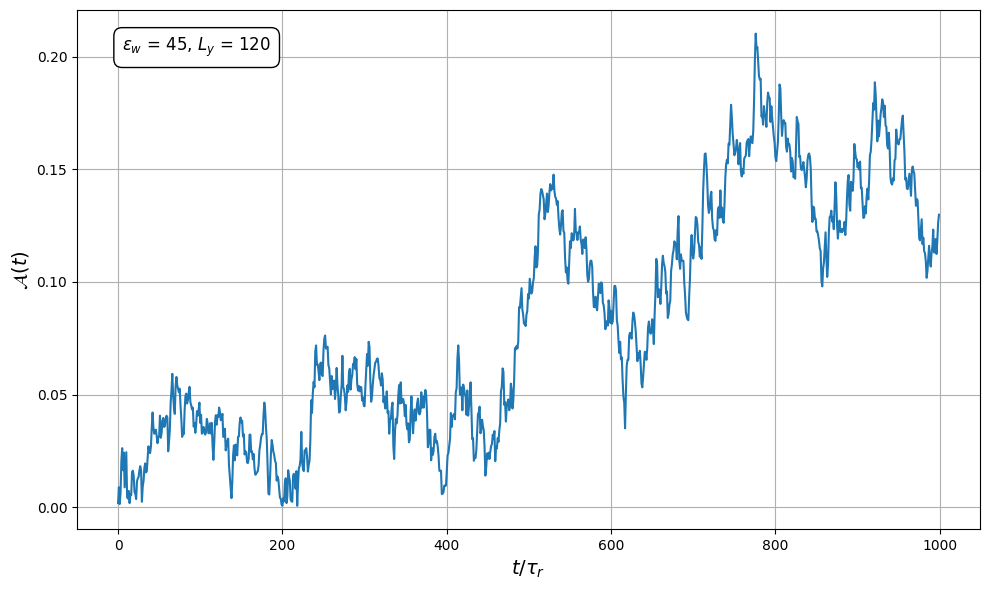

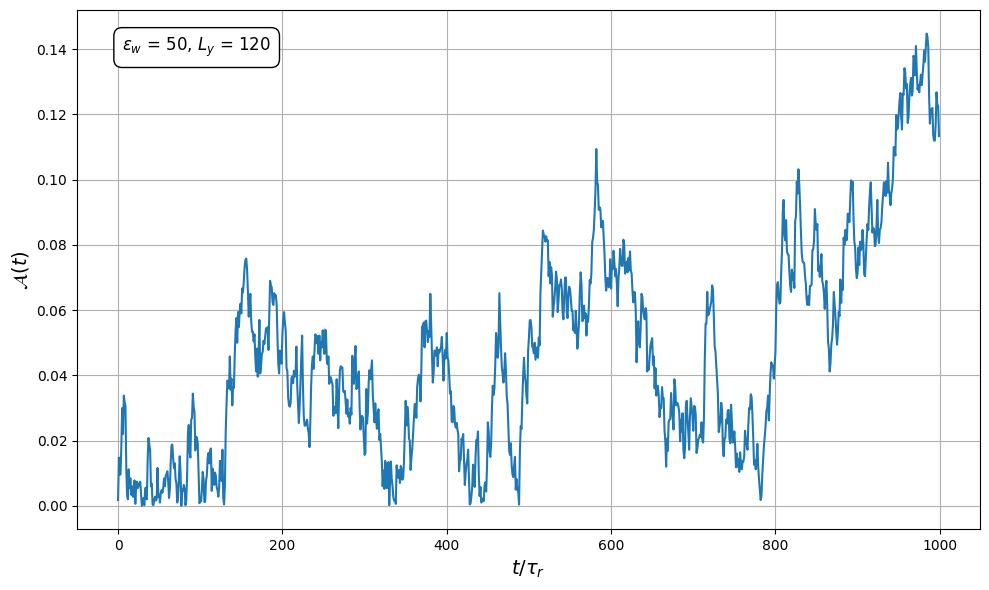

In [50]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt

def plot_asymmetry_vs_time(filename, lx, rho_ld, rho, taur):
    """
    Compute and plot the asymmetry order parameter A(t) as a function of t/taur for a given dump file.
    Estimate the steady-state relaxation time tau_c based on the rate of change of A(t).
    """
    data = load_profile(filename)
    # Compute asymmetry at each timestep
    asymmetry_list = []
    timesteps = []
    grouped = data.groupby('Timestep')
    for timestep, df_timestep in grouped:
        asymmetry = calculate_asymmetry(df_timestep, lx=lx, rho_ld=rho_ld, rho=rho)
        asymmetry_list.append(asymmetry)
        timesteps.append(timestep)

    # Convert to numpy arrays
    asymmetry_array = np.array(asymmetry_list)
    timestep_array = np.array(timesteps)

    # Sort by timestep
    sorted_indices = np.argsort(timestep_array)
    timestep_array = timestep_array[sorted_indices]
    asymmetry_array = asymmetry_array[sorted_indices]

    # Calculate t / taur
    dt = 0.00004 * taur
    t_over_taur = timestep_array * dt / taur  # Simplifies to timestep_array * 0.00004

    # Extract epsilon_w from filename
    # filename format: 'wet.<timestamp>.eps.<epsilon_w>.ly.<ly>.dump'
    pattern = r'wet\..*\.eps\.(\d+)\.ly\.(\d+)\.dump'
    match = re.match(pattern, os.path.basename(filename))
    if match:
        epsilon_w = match.group(1)
        ly = match.group(2)
    else:
        epsilon_w = 'Unknown'
        ly = 'Unknown'

    # Plot A(t) vs t / taur
    plt.figure(figsize=(10, 6))
    plt.plot(t_over_taur, asymmetry_array, linestyle='-', label=r'$\mathcal{A}(t)$')
    plt.xlabel(r'$t / \tau_r$', fontsize=14)
    plt.ylabel(r'$\mathcal{A}(t)$', fontsize=14)
    plt.text(0.05, 0.95, f'$\\epsilon_w$ = {epsilon_w}, $L_y$ = {ly}',
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return t_over_taur, asymmetry_array

def compute_taur():
    """
    Compute the persistence time tau_r based on the LAMMPS input script variables.
    """
    sigma = 1.0
    wcaepsilon = 1.0    
    friction = 50.0
    Pe = 50.0
    activity = 24 * wcaepsilon / (sigma * friction)  # activity = 24*epsilon/(sigma*friction)
    T = activity * friction * sigma / (3 * Pe)  # temperature
    Dr = 3 * T / (friction * sigma**2)  # rotational diffusion
    taur = 1 / Dr  # persistence time
    return taur

# Main script
if __name__ == "__main__":
    folder = "dumps"  # Folder containing dump files
    lx = 240.0  # Total system size in x-direction
    rho_ld = 0.15  # Low-density MIPS value
    rho = 0.5  # Total system density
    # Compute taur
    taur = compute_taur()
    print(f"Computed tau_r (persistence time): {taur}")

    # Plot asymmetry vs time for multiple dump files
    for eps in range(20, 51, 5):  # Iterate over eps values: 20, 25, 30, ..., 50
        filename = os.path.join(folder, f'wet.241206.0213.eps.{eps}.ly.120.dump')
        if os.path.exists(filename):
            t_over_taur, asymmetry_array = plot_asymmetry_vs_time(filename, lx=lx, rho_ld=rho_ld, rho=rho, taur=taur)
        # else:
            # print(f"File {filename} does not exist.")

/var/folders/8c/54xdylrd32q5q2h0h83vhjm00000gn/T/ipykernel_81638/454310735.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r')


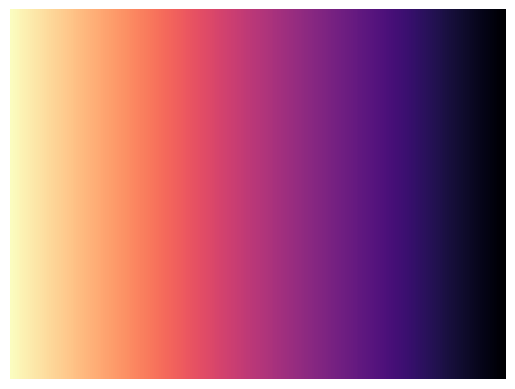

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define reversed Magma colormap
cmap = plt.cm.get_cmap('magma_r')

# Create a horizontal gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 50)  # Repeat vertically for visibility

# Save gradient as an image
plt.imshow(gradient, aspect='auto', cmap=cmap)
plt.axis('off')
plt.savefig("magma_r_gradient.png", bbox_inches='tight', pad_inches=0)
plt.show()
